# Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

## Setup Environment

In [1]:
import json
# We omit warnings to keep the output clean
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt 
import nltk

from common_utils import load_glove_embeddings, set_seed, EmbeddingMatrix, EarlyStopper, EmbeddingsDataset

In [2]:
# set seed 
set_seed()

# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 
EMBEDDING_DIM=100
GRADIENT_CLIP=5

In [3]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

Let's add the padding token to the word embeddings.

In [4]:
# initialize word embeddings
word_embeddings = EmbeddingMatrix.load()
word_embeddings.add_padding()
word_embeddings.handle_unknown = False

print("The index of <PAD> is: ", word_embeddings.pad_idx)

print(word_embeddings.to_tensor[word_embeddings.pad_idx])

The index of <PAD> is:  16163
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [5]:
def pad_collate(batch, pad_value):
    (xx, yy) = zip(*batch)
    # convert xx to a tensor
    xx = [torch.tensor(x, dtype=torch.int64) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.tensor(yy, dtype=torch.long)

### Datasets and Dataloaders

As we are performing mini-batch processing, at each batch, the length of sequence of each input has to be the same. To tackle the issue of different sequence lengths, we used <PAD> token.

Here, we create the datasets and dataloaders for the training, validation, and test sets. We also use the `pad_collate` function to pad the sequences in each batch.

Noted that we have a sorted version of the dataset as well. We use it to explore if a sorted dataset helps with our training. This will be elaborated later.

In [92]:
train_dataset_ed = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"],
    word_embeddings=word_embeddings
)
validation_dataset_ed = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"],
    word_embeddings=word_embeddings
)
test_dataset_ed = EmbeddingsDataset(test_dataset["text"], test_dataset["label"],
    word_embeddings=word_embeddings)

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader = DataLoader(
    train_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader = DataLoader(
    validation_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
test_dataloader = DataLoader(
    test_dataset_ed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

In [7]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [8]:
def train_loop_bce(train_dataloader, model, loss_fn, optimizer, clipping = True):
    if train_on_gpu:
        model.cuda()
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        if train_on_gpu:
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        
        # Forward pass
        pred = model(X_batch)
        
        pred = pred.squeeze(1)
        pred_binary = (pred >= 0.5).long()
        loss = loss_fn(pred, y_batch.float())
        train_loss += loss.item() 
        train_correct += (pred_binary==y_batch.long()).sum().item() 
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
        
        optimizer.step()
    
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 

def test_loop_bce(validate_dataloader, model, loss_fn):
    if train_on_gpu:
        model.cuda()
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_loss += loss_fn(pred, y_batch.float()).item()
            test_correct += (pred_binary == y_batch.long()).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

def test_performance(test_dataloader, model):
    if train_on_gpu:
        model.cuda()
    model.eval()
    size = len(test_dataloader.dataset)
    test_correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            if train_on_gpu:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).long()
            test_correct += (pred_binary == y_batch.long()).sum().item()
    
    test_correct /= size
    return test_correct

### Training Function with & without Early Stop

We have two seperate train function, `train` and `train_early_stop`.

`train_early_stop` utilise early stopping, a standard practice to prevent overfitting. The early stopping algorithm has a default patience of 3, so the training of the model stops if the validation loss does not decrease after 3 epochs. 


In [9]:
def train(model, optim, criterion, training_dataloader, validation_dataloader, epoch = NUM_EPOCHS, clipping = True):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  for i in range(epoch):
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim, clipping) 
    validate_loss, validate_correct = test_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
  return train_acc, validation_acc, train_losses, validate_losses

In [10]:
def train_early_stop(model, optim, criterion, training_dataloader, validation_dataloader, clipping = True, patience = 3):
  validation_acc = [] 
  train_acc = []
  train_losses, validate_losses = [], []
  early_stopper = EarlyStopper(patience=patience)
  i = 0
  while True:
    train_loss, train_correct = train_loop_bce(training_dataloader, model, criterion, optim, clipping) 
    validate_loss, validate_correct = test_loop_bce(validation_dataloader, model, criterion)
    validation_acc.append(validate_correct)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    validate_losses.append(validate_loss)

    print(f"Epoch {i+1}, Train Loss: {train_loss:.4f}, Validate Loss: {validate_loss:.4f}")
    #if i%10 == 0:
    print(f"Epoch:{i+1} \t Train Acc:{train_correct} \t Validation Acc:{validate_correct}")
    if early_stopper.early_stop(validate_loss):
        print("Early stopping")
        break
    i += 1
  return train_acc, validation_acc, train_losses, validate_losses

In [11]:
def plot(a: dict, x_label = "", y_label = "", title = ""):
    for key in a:
        plt.plot(a[key], label=key)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

# Exploration

### Base RNN Model

Our base vanilla RNN will use the last hidden state (hn(w)) at the last step and then pass it as an input into the Fully Connected (FC) layer.

In [47]:
# using nn.Embeddings 
class VanillaRNNLastHidden(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,  embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(VanillaRNNLastHidden, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, hidden = self.rnn(x, h0)
        # Max pooling
        #out, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = hidden[-1]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res


### Fixed Length or Variable Length

To pad the sentence, we can either 
1. Fixed Length: set a fixed length for all the sentences, pad the shorter sentences with 0s and truncate the longer sentences, or
2. Variable Length: pad the entire sentences dynamically during batching using `torch,nn.utils.rnn.pad_sequence`. The second method is declared above.

#### Fixed Length

In [14]:
# initialize word embeddings
_word_embeddings = load_glove_embeddings()

_embeddings = [_word_embeddings[word] for word in _word_embeddings.keys()]

embedding_matrix_no_mask = np.array(_embeddings)
embedding_matrix_no_mask = np.vstack((embedding_matrix_no_mask, np.zeros((1, 100)))) # add a row of zeros for padding

print(embedding_matrix_no_mask.shape)

Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000
(400001, 100)


In [15]:
# TODO: change the num_tokens 
class FixedLengthEmbeddingsDataset(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=25, word_embeddings=_word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.long)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x.lower())
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [(embedding_matrix_no_mask.shape[0] - 1 ) for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)
    #print(indices)
    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  

In [16]:
no_mask_train_dataset_ed = FixedLengthEmbeddingsDataset(train_dataset['text'], train_dataset['label'])
no_mask_validation_dataset_ed = FixedLengthEmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
no_mask_test_dataset_ed = FixedLengthEmbeddingsDataset(test_dataset['text'], test_dataset['label'])

# implement minibatch training 
no_mask_train_dataloader = DataLoader(no_mask_train_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
no_mask_validation_dataloader = DataLoader(no_mask_validation_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
no_mask_test_dataloader = DataLoader(no_mask_test_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
vanilla_rnn = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=torch.tensor(embedding_matrix_no_mask, dtype=torch.float), padding_idx=embedding_matrix_no_mask.shape[0]-1)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_unmask, validation_acc_vanilla_rnn_unmask, train_loss_vanilla_rnn_unmask, validation_loss_vanilla_rnn_unmask = train(vanilla_rnn, optim, criterion, no_mask_train_dataloader, no_mask_validation_dataloader, epoch=50, clipping=False)

Epoch 1, Train Loss: 0.6933, Validate Loss: 0.6944
Epoch:1 	 Train Acc:0.5050410316529894 	 Validation Acc:0.49343339587242024
Epoch 2, Train Loss: 0.6890, Validate Loss: 0.6959
Epoch:2 	 Train Acc:0.5283704572098475 	 Validation Acc:0.50187617260788
Epoch 3, Train Loss: 0.6835, Validate Loss: 0.6962
Epoch:3 	 Train Acc:0.5420867526377491 	 Validation Acc:0.5140712945590994
Epoch 4, Train Loss: 0.6772, Validate Loss: 0.6974
Epoch:4 	 Train Acc:0.5650644783118406 	 Validation Acc:0.5159474671669794
Epoch 5, Train Loss: 0.6691, Validate Loss: 0.7002
Epoch:5 	 Train Acc:0.5785463071512309 	 Validation Acc:0.5356472795497186
Epoch 6, Train Loss: 0.6645, Validate Loss: 0.6921
Epoch:6 	 Train Acc:0.5924970691676437 	 Validation Acc:0.5318949343339587
Epoch 7, Train Loss: 0.6581, Validate Loss: 0.6926
Epoch:7 	 Train Acc:0.6005861664712778 	 Validation Acc:0.5469043151969981
Epoch 8, Train Loss: 0.6534, Validate Loss: 0.6970
Epoch:8 	 Train Acc:0.6099648300117233 	 Validation Acc:0.5450281425

Let us plot the training and validation accuracy without early stopping first to see how the model is performing.

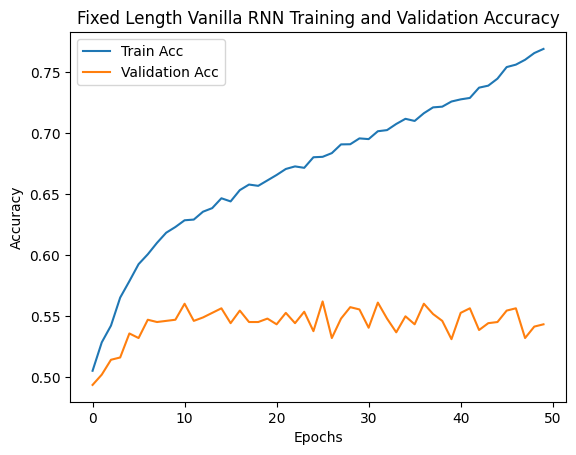

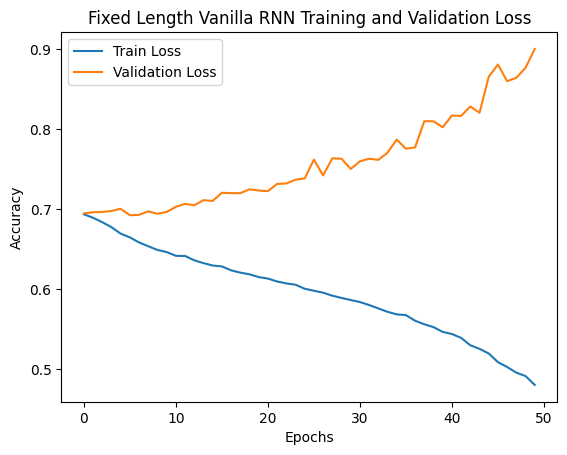

best performance (lowest validation loss) with validation acc: 0.5318949343339587 validation loss: 0.6921213269233704


In [18]:
plot({"Train Acc": train_acc_vanilla_rnn_unmask, "Validation Acc": validation_acc_vanilla_rnn_unmask}, x_label="Epochs", y_label="Accuracy", title="Fixed Length Vanilla RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_vanilla_rnn_unmask, "Validation Loss": validation_loss_vanilla_rnn_unmask}, x_label="Epochs", y_label="Accuracy", title="Fixed Length Vanilla RNN Training and Validation Loss")

i = validation_loss_vanilla_rnn_unmask.index(min(validation_loss_vanilla_rnn_unmask))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_unmask[i], "validation loss:", validation_loss_vanilla_rnn_unmask[i])

It seems the model overfits quite fast, let's try now with early stopping.

In [28]:
vanilla_rnn = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=torch.tensor(embedding_matrix_no_mask, dtype=torch.float), padding_idx=embedding_matrix_no_mask.shape[0]-1)
optim = torch.optim.Adam(vanilla_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn, optim, criterion, no_mask_train_dataloader, no_mask_validation_dataloader, clipping=False, patience=5)

Epoch 1, Train Loss: 0.6936, Validate Loss: 0.6932
Epoch:1 	 Train Acc:0.5053927315357561 	 Validation Acc:0.50187617260788
Epoch 2, Train Loss: 0.6892, Validate Loss: 0.6959
Epoch:2 	 Train Acc:0.5243845252051582 	 Validation Acc:0.4971857410881801
Epoch 3, Train Loss: 0.6845, Validate Loss: 0.6948
Epoch:3 	 Train Acc:0.5396248534583822 	 Validation Acc:0.5187617260787992
Epoch 4, Train Loss: 0.6772, Validate Loss: 0.6951
Epoch:4 	 Train Acc:0.5611957796014068 	 Validation Acc:0.5272045028142589
Epoch 5, Train Loss: 0.6695, Validate Loss: 0.7110
Epoch:5 	 Train Acc:0.5818288393903869 	 Validation Acc:0.5412757973733584
Epoch 6, Train Loss: 0.6628, Validate Loss: 0.6986
Epoch:6 	 Train Acc:0.6005861664712778 	 Validation Acc:0.5422138836772983
Early stopping


In [29]:
print("Current model performance with validation acc:", validation_acc_vanilla_rnn[-1], "validation loss:", validation_loss_vanilla_rnn[-1], "\n")

test_accuracy_fixed = test_performance(no_mask_test_dataloader, vanilla_rnn)
print("Fixed Length Vanilla RNN (last hidden state) Test accuracy:", test_accuracy_fixed)

Current model performance with validation acc: 0.5422138836772983 validation loss: 0.6985997785540188 

Fixed Length Vanilla RNN (last hidden state) Test accuracy: 0.5525328330206379


#### Variable Length

In [21]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=False)

Epoch 1, Train Loss: 0.6934, Validate Loss: 0.6923
Epoch:1 	 Train Acc:0.5004689331770222 	 Validation Acc:0.5
Epoch 2, Train Loss: 0.6934, Validate Loss: 0.6940
Epoch:2 	 Train Acc:0.48792497069167645 	 Validation Acc:0.48592870544090055
Epoch 3, Train Loss: 0.6931, Validate Loss: 0.6932
Epoch:3 	 Train Acc:0.5024618991793669 	 Validation Acc:0.5112570356472795
Epoch 4, Train Loss: 0.6927, Validate Loss: 0.6935
Epoch:4 	 Train Acc:0.4985932004689332 	 Validation Acc:0.49624765478424016
Epoch 5, Train Loss: 0.6922, Validate Loss: 0.6929
Epoch:5 	 Train Acc:0.5029308323563892 	 Validation Acc:0.5440900562851783
Epoch 6, Train Loss: 0.6928, Validate Loss: 0.6933
Epoch:6 	 Train Acc:0.512778429073857 	 Validation Acc:0.5121951219512195
Epoch 7, Train Loss: 0.6682, Validate Loss: 0.6351
Epoch:7 	 Train Acc:0.5847596717467761 	 Validation Acc:0.6585365853658537
Epoch 8, Train Loss: 0.5973, Validate Loss: 0.5864
Epoch:8 	 Train Acc:0.6901524032825322 	 Validation Acc:0.7063789868667918
Epoch

Let us plot the training and validation accuracy without early stopping first as well.

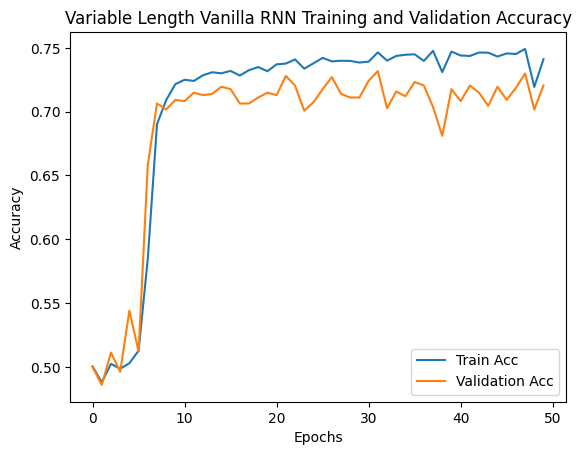

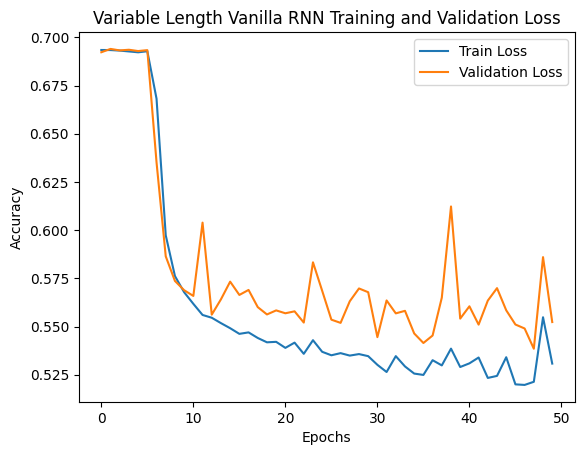

best performance (lowest validation loss) with validation acc: 0.7298311444652908 validation loss: 0.5385046469814637


In [22]:
plot({"Train Acc": train_acc_vanilla_rnn, "Validation Acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_vanilla_rnn, "Validation Loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Loss")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

Let's train with early stopping now!

In [23]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_vanilla_rnn, validation_acc_vanilla_rnn, train_loss_vanilla_rnn, validation_loss_vanilla_rnn = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, clipping=False, patience=10)

Epoch 1, Train Loss: 0.6934, Validate Loss: 0.6943
Epoch:1 	 Train Acc:0.5031652989449004 	 Validation Acc:0.49624765478424016
Epoch 2, Train Loss: 0.6936, Validate Loss: 0.6936
Epoch:2 	 Train Acc:0.4970691676436108 	 Validation Acc:0.49906191369606
Epoch 3, Train Loss: 0.6928, Validate Loss: 0.6925
Epoch:3 	 Train Acc:0.5062133645955451 	 Validation Acc:0.5065666041275797
Epoch 4, Train Loss: 0.6924, Validate Loss: 0.6902
Epoch:4 	 Train Acc:0.5012895662368112 	 Validation Acc:0.5112570356472795
Epoch 5, Train Loss: 0.6861, Validate Loss: 0.7432
Epoch:5 	 Train Acc:0.5399765533411489 	 Validation Acc:0.5234521575984991
Epoch 6, Train Loss: 0.6936, Validate Loss: 0.6906
Epoch:6 	 Train Acc:0.5085580304806565 	 Validation Acc:0.5150093808630394
Epoch 7, Train Loss: 0.6844, Validate Loss: 0.6870
Epoch:7 	 Train Acc:0.5539273153575616 	 Validation Acc:0.5337711069418386
Epoch 8, Train Loss: 0.6908, Validate Loss: 0.7097
Epoch:8 	 Train Acc:0.5207502930832356 	 Validation Acc:0.5140712945

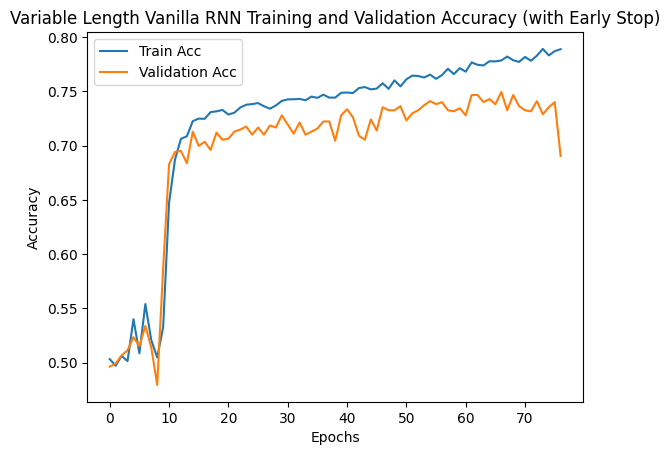

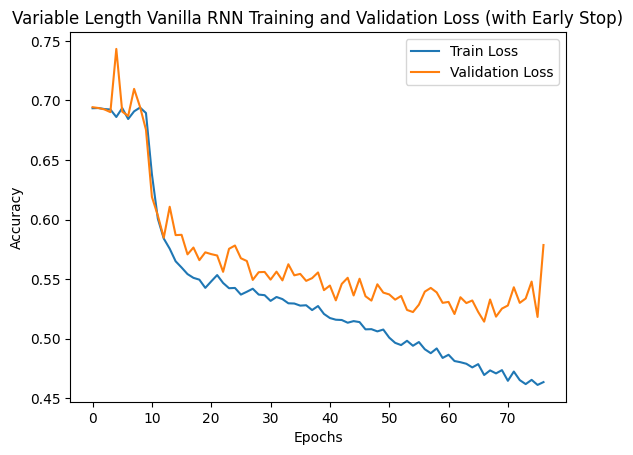

best performance (lowest validation loss) with validation acc: 0.7495309568480301 validation loss: 0.514304922784076


In [24]:
plot({"Train Acc": train_acc_vanilla_rnn, "Validation Acc": validation_acc_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Accuracy (with Early Stop)")
plot({"Train Loss": train_loss_vanilla_rnn, "Validation Loss": validation_loss_vanilla_rnn}, x_label="Epochs", y_label="Accuracy", title="Variable Length Vanilla RNN Training and Validation Loss (with Early Stop)")

i = validation_loss_vanilla_rnn.index(min(validation_loss_vanilla_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn[i], "validation loss:", validation_loss_vanilla_rnn[i])

In [25]:
print("Variable Length Vanilla RNN performance with validation acc:", validation_acc_vanilla_rnn[-1], "validation loss:", validation_loss_vanilla_rnn[-1], "\n")

test_accuracy_variable = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Variable Length Vanilla RNN (last hidden state) Test accuracy:", test_accuracy_variable)

Variable Length Vanilla RNN performance with validation acc: 0.6904315196998124 validation loss: 0.5786393048132167 

Variable Length Vanilla RNN (last hidden state) Test accuracy: 0.7298311444652908


##### Some cool observation:

Notice if learning rate is higher than 0.0001 (e.g. >0.0002 here), the model will not converge.

In [26]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0002)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_high, validation_acc_vanilla_rnn_high, train_loss_vanilla_rnn_high, validation_loss_vanilla_rnn_high = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=False)

Epoch 1, Train Loss: 0.6937, Validate Loss: 0.6940
Epoch:1 	 Train Acc:0.5053927315357561 	 Validation Acc:0.5
Epoch 2, Train Loss: 0.6933, Validate Loss: 0.6927
Epoch:2 	 Train Acc:0.4978898007033998 	 Validation Acc:0.4915572232645403
Epoch 3, Train Loss: 0.6933, Validate Loss: 0.6943
Epoch:3 	 Train Acc:0.4990621336459555 	 Validation Acc:0.49624765478424016
Epoch 4, Train Loss: 0.6932, Validate Loss: 0.6934
Epoch:4 	 Train Acc:0.4974208675263775 	 Validation Acc:0.5065666041275797
Epoch 5, Train Loss: 0.6923, Validate Loss: 0.6936
Epoch:5 	 Train Acc:0.5023446658851114 	 Validation Acc:0.49906191369606
Epoch 6, Train Loss: 0.6945, Validate Loss: 0.6943
Epoch:6 	 Train Acc:0.5060961313012896 	 Validation Acc:0.5131332082551595
Epoch 7, Train Loss: 0.6931, Validate Loss: 0.6930
Epoch:7 	 Train Acc:0.5056271981242673 	 Validation Acc:0.5121951219512195
Epoch 8, Train Loss: 0.6914, Validate Loss: 0.6922
Epoch:8 	 Train Acc:0.5200468933177023 	 Validation Acc:0.5168855534709194
Epoch 9,

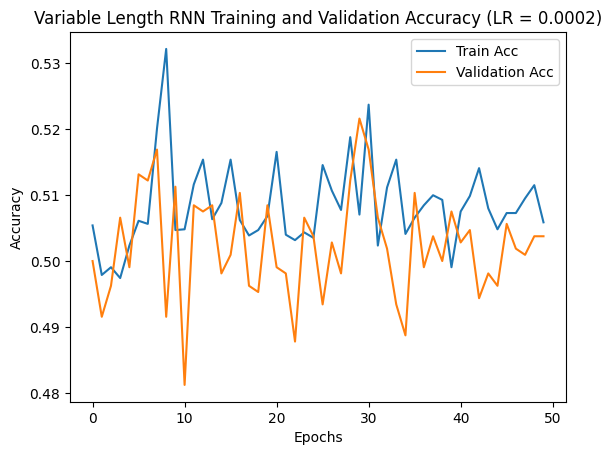

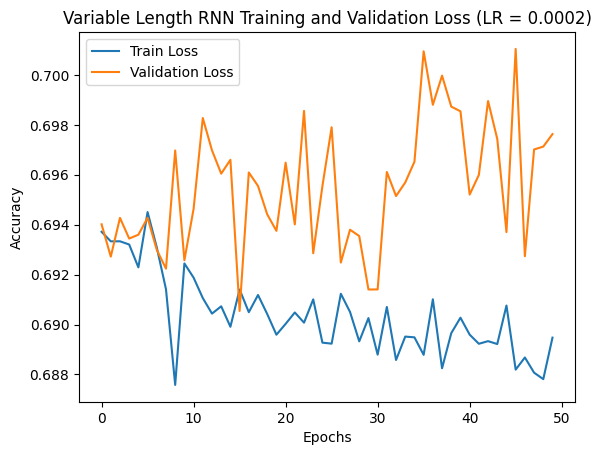

best performance (lowest validation loss) with validation acc: 0.50093808630394 validation loss: 0.6905452538939083


In [27]:
plot({"Train Acc": train_acc_vanilla_rnn_high, "Validation Acc": validation_acc_vanilla_rnn_high}, x_label="Epochs", y_label="Accuracy", title="Variable Length RNN Training and Validation Accuracy (LR = 0.0002)")
plot({"Train Loss": train_loss_vanilla_rnn_high, "Validation Loss": validation_loss_vanilla_rnn_high}, x_label="Epochs", y_label="Accuracy", title="Variable Length RNN Training and Validation Loss (LR = 0.0002)")

i = validation_loss_vanilla_rnn_high.index(min(validation_loss_vanilla_rnn_high))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_high[i], "validation loss:", validation_loss_vanilla_rnn_high[i])

### Gradient Clipping

We notice that there is a drastic changes during the training.

We decide to introduce gradient clipping to take a much smaller step when updating the gradient. 

With this, we can update the gradient much smoother and reduce the risk of overshooting during optimization. This helps the model converge more steadily, as shown below.

In [83]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_vanilla_rnn_clip, validation_acc_vanilla_rnn_clip, train_loss_vanilla_rnn_clip, validation_loss_vanilla_rnn_clip = train(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, epoch=50, clipping=True)

Epoch 1, Train Loss: 0.6938, Validate Loss: 0.6923
Epoch:1 	 Train Acc:0.494021101992966 	 Validation Acc:0.5
Epoch 2, Train Loss: 0.6935, Validate Loss: 0.6924
Epoch:2 	 Train Acc:0.4992966002344666 	 Validation Acc:0.5046904315196998
Epoch 3, Train Loss: 0.6930, Validate Loss: 0.6916
Epoch:3 	 Train Acc:0.5019929660023447 	 Validation Acc:0.5121951219512195
Epoch 4, Train Loss: 0.6928, Validate Loss: 0.6936
Epoch:4 	 Train Acc:0.5039859320046893 	 Validation Acc:0.49437148217636023
Epoch 5, Train Loss: 0.6921, Validate Loss: 0.6923
Epoch:5 	 Train Acc:0.5023446658851114 	 Validation Acc:0.5121951219512195
Epoch 6, Train Loss: 0.6923, Validate Loss: 0.6898
Epoch:6 	 Train Acc:0.5022274325908558 	 Validation Acc:0.5290806754221389
Epoch 7, Train Loss: 0.6438, Validate Loss: 0.6354
Epoch:7 	 Train Acc:0.6356389214536928 	 Validation Acc:0.6604127579737336
Epoch 8, Train Loss: 0.5927, Validate Loss: 0.6113
Epoch:8 	 Train Acc:0.7001172332942556 	 Validation Acc:0.6960600375234521
Epoch 9

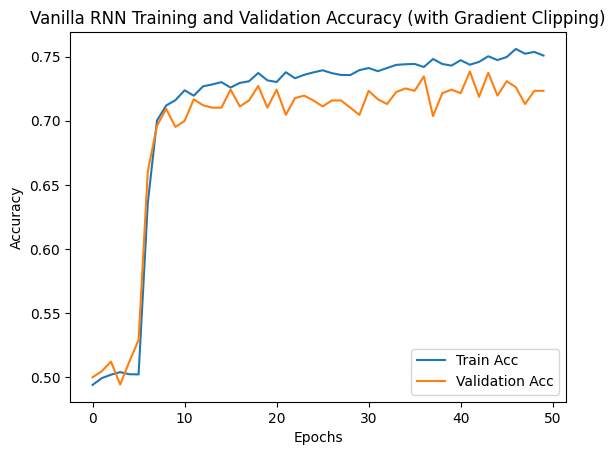

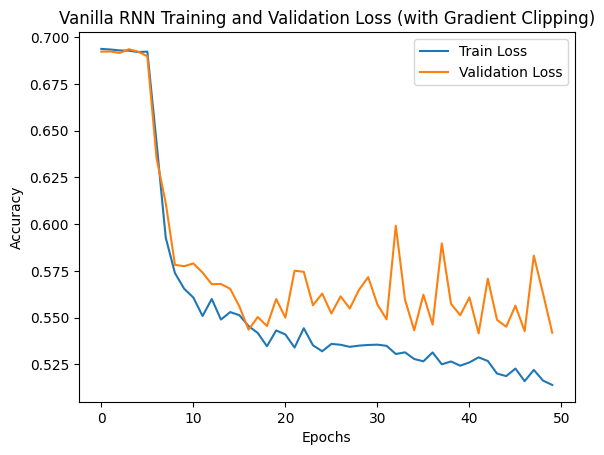

best performance (lowest validation loss) with validation acc: 0.7382739212007504 validation loss: 0.5414997812579659


In [84]:
plot({"Train Acc": train_acc_vanilla_rnn_clip, "Validation Acc": validation_acc_vanilla_rnn_clip}, x_label="Epochs", y_label="Accuracy", title="Vanilla RNN Training and Validation Accuracy (with Gradient Clipping)")
plot({"Train Loss": train_loss_vanilla_rnn_clip, "Validation Loss": validation_loss_vanilla_rnn_clip}, x_label="Epochs", y_label="Accuracy", title="Vanilla RNN Training and Validation Loss (with Gradient Clipping)")

i = validation_loss_vanilla_rnn_clip.index(min(validation_loss_vanilla_rnn_clip))
print("best performance (lowest validation loss) with validation acc:", validation_acc_vanilla_rnn_clip[i], "validation loss:", validation_loss_vanilla_rnn_clip[i])

We noticed that after implementing gradient clipping by norm and we achieved, although still steep, but at least a smaller step in the gradient update as shown below. This should hopefully prevent bad updates in our training.

Let's check if the test accuracy is improved.

In [85]:
vanilla_rnn_hidden = VanillaRNNLastHidden(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(vanilla_rnn_hidden.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_vanilla_rnn_clip_2, validation_acc_vanilla_rnn_clip_2, train_loss_vanilla_rnn_clip_2, validation_loss_vanilla_rnn_clip_2 = train_early_stop(vanilla_rnn_hidden, optim, criterion, train_dataloader, validation_dataloader, clipping=True, patience=10)

Epoch 1, Train Loss: 0.6936, Validate Loss: 0.6941
Epoch:1 	 Train Acc:0.5052754982415005 	 Validation Acc:0.50093808630394
Epoch 2, Train Loss: 0.6934, Validate Loss: 0.6932
Epoch:2 	 Train Acc:0.49390386869871045 	 Validation Acc:0.4971857410881801
Epoch 3, Train Loss: 0.6933, Validate Loss: 0.6931
Epoch:3 	 Train Acc:0.4930832356389215 	 Validation Acc:0.49530956848030017
Epoch 4, Train Loss: 0.6928, Validate Loss: 0.6925
Epoch:4 	 Train Acc:0.5050410316529894 	 Validation Acc:0.5037523452157598
Epoch 5, Train Loss: 0.6928, Validate Loss: 0.6923
Epoch:5 	 Train Acc:0.500820633059789 	 Validation Acc:0.50187617260788
Epoch 6, Train Loss: 0.6657, Validate Loss: 0.6156
Epoch:6 	 Train Acc:0.6008206330597889 	 Validation Acc:0.6819887429643527
Epoch 7, Train Loss: 0.6032, Validate Loss: 0.6022
Epoch:7 	 Train Acc:0.6876905041031653 	 Validation Acc:0.6951219512195121
Epoch 8, Train Loss: 0.5802, Validate Loss: 0.5856
Epoch:8 	 Train Acc:0.7077373974208675 	 Validation Acc:0.709193245778

In [86]:
print("Current Vanilla RNN (with Gradient Clipping) performance with validation acc:", validation_acc_vanilla_rnn_clip_2[-1], "validation loss:", validation_loss_vanilla_rnn_clip_2[-1], "\n")

test_accuracy_gradient = test_performance(test_dataloader, vanilla_rnn_hidden)
print("Vanilla RNN (with Gradient Clipping) Test accuracy:", test_accuracy_gradient)

Current Vanilla RNN (with Gradient Clipping) performance with validation acc: 0.7363977485928705 validation loss: 0.5277842002756455 

Vanilla RNN (with Gradient Clipping) Test accuracy: 0.7485928705440901


We noticed the test accuracy is basically unchanged, as we now have 0.721 test accuracy while previously we had 0.738 test accuracy.

This indicates Gradient Clipping doesn't help much in improving accuracy in our scenario. However, it should still help with preventing bad updates.

Let's see whether it improves the test accuracy!

### Max pooling, Sum pooling and Avg Pooling

#### Last output RNN

In [76]:
# using nn.Embeddings 
class LastOutputRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(LastOutputRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Get the last output for each sequence
        res = out[:, -1, :]
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

Let's observe the model performance without early stopping!

In [81]:
last_output_rnn = LastOutputRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(last_output_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_last_output, validation_acc_last_output, train_loss_last_output, validation_loss_last_output = train(last_output_rnn, optim, criterion, train_dataloader, validation_dataloader, epoch=50)

Epoch 1, Train Loss: 0.6936, Validate Loss: 0.6925
Epoch:1 	 Train Acc:0.4969519343493552 	 Validation Acc:0.5112570356472795
Epoch 2, Train Loss: 0.6934, Validate Loss: 0.6927
Epoch:2 	 Train Acc:0.500820633059789 	 Validation Acc:0.49624765478424016
Epoch 3, Train Loss: 0.6930, Validate Loss: 0.6934
Epoch:3 	 Train Acc:0.501875732708089 	 Validation Acc:0.5046904315196998
Epoch 4, Train Loss: 0.6929, Validate Loss: 0.6920
Epoch:4 	 Train Acc:0.5046893317702228 	 Validation Acc:0.5
Epoch 5, Train Loss: 0.6927, Validate Loss: 0.6936
Epoch:5 	 Train Acc:0.5003516998827667 	 Validation Acc:0.5037523452157598
Epoch 6, Train Loss: 0.6921, Validate Loss: 0.6953
Epoch:6 	 Train Acc:0.5126611957796015 	 Validation Acc:0.5
Epoch 7, Train Loss: 0.6915, Validate Loss: 0.6924
Epoch:7 	 Train Acc:0.5154747948417351 	 Validation Acc:0.5168855534709194
Epoch 8, Train Loss: 0.6914, Validate Loss: 0.6915
Epoch:8 	 Train Acc:0.5182883939038687 	 Validation Acc:0.49530956848030017
Epoch 9, Train Loss: 0

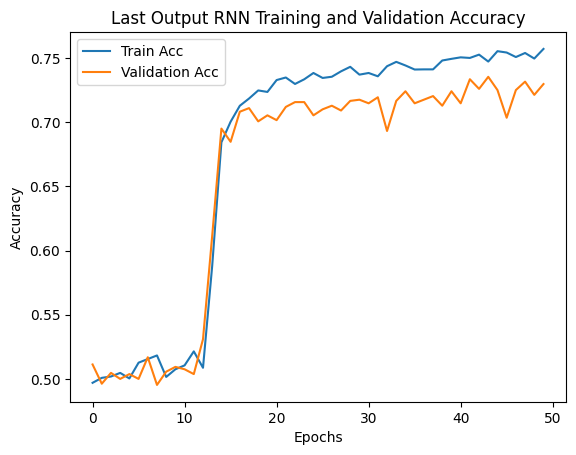

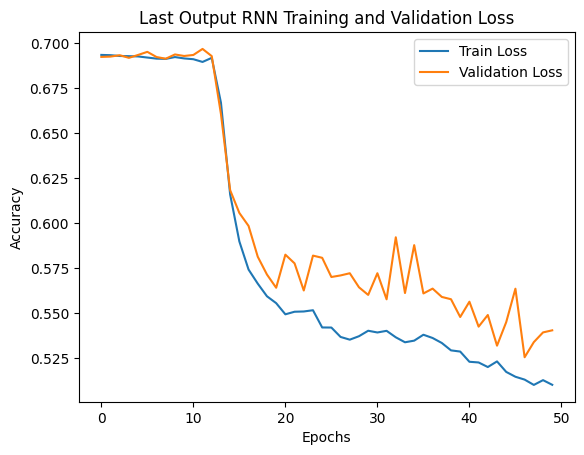

best performance (lowest validation loss) with validation acc: 0.725140712945591 validation loss: 0.5253757589003619


In [82]:
plot({"Train Acc": train_acc_last_output, "Validation Acc": validation_acc_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_last_output, "Validation Loss": validation_loss_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Loss")

i = validation_loss_last_output.index(min(validation_loss_last_output))
print("best performance (lowest validation loss) with validation acc:", validation_acc_last_output[i], "validation loss:", validation_loss_last_output[i])

With early stopping:

In [ ]:
last_output_rnn = LastOutputRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(last_output_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

# Since the model learns much slower, we increase the patience to 10
train_acc_last_output, validation_acc_last_output, train_loss_last_output, validation_loss_last_output = train_early_stop(last_output_rnn, optim, criterion, train_dataloader, validation_dataloader, patience = 10)

Epoch 1, Train Loss: 0.6931, Validate Loss: 0.6924
Epoch:1 	 Train Acc:0.5137162954279015 	 Validation Acc:0.5103189493433395
Epoch 2, Train Loss: 0.6935, Validate Loss: 0.6928
Epoch:2 	 Train Acc:0.49343493552168816 	 Validation Acc:0.4915572232645403
Epoch 3, Train Loss: 0.6932, Validate Loss: 0.6928
Epoch:3 	 Train Acc:0.49636576787807735 	 Validation Acc:0.4924953095684803
Epoch 4, Train Loss: 0.6929, Validate Loss: 0.6920
Epoch:4 	 Train Acc:0.4928487690504103 	 Validation Acc:0.5150093808630394
Epoch 5, Train Loss: 0.6929, Validate Loss: 0.6904
Epoch:5 	 Train Acc:0.5017584994138335 	 Validation Acc:0.5234521575984991
Epoch 6, Train Loss: 0.6867, Validate Loss: 0.6927
Epoch:6 	 Train Acc:0.5227432590855803 	 Validation Acc:0.6060037523452158
Epoch 7, Train Loss: 0.6248, Validate Loss: 0.6022
Epoch:7 	 Train Acc:0.6686987104337632 	 Validation Acc:0.6885553470919324
Epoch 8, Train Loss: 0.5879, Validate Loss: 0.5792
Epoch:8 	 Train Acc:0.7029308323563892 	 Validation Acc:0.7120075

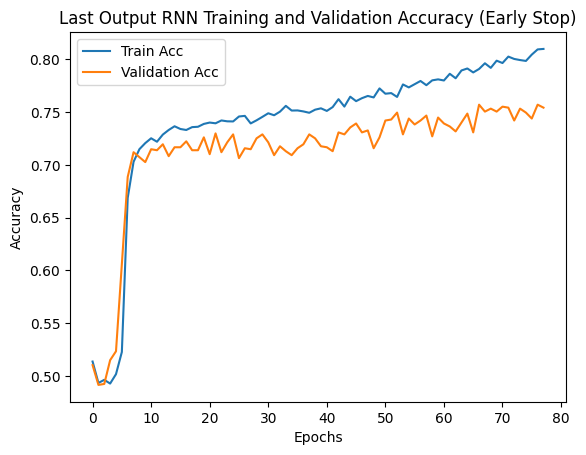

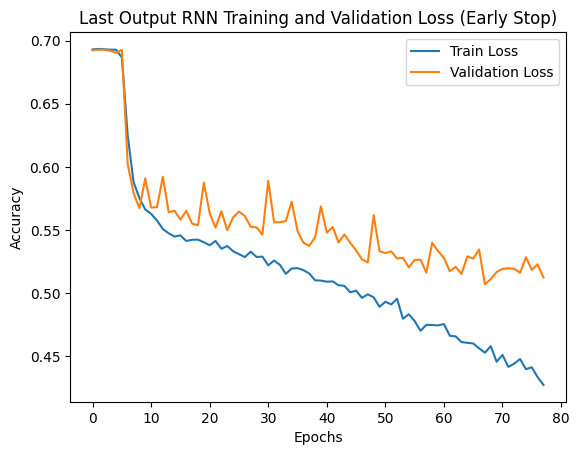

best performance (lowest validation loss) with validation acc: 0.7504690431519699 validation loss: 0.5069280135280946


In [78]:
plot({"Train Acc": train_acc_last_output, "Validation Acc": validation_acc_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_last_output, "Validation Loss": validation_loss_last_output}, x_label="Epochs", y_label="Accuracy", title="Last Output RNN Training and Validation Loss (Early Stop)")

i = validation_loss_last_output.index(min(validation_loss_last_output))
print("best performance (lowest validation loss) with validation acc:", validation_acc_last_output[i], "validation loss:", validation_loss_last_output[i])

In [79]:
print("Last Output RNN performance with validation acc:", validation_acc_last_output[-1], "validation loss:", validation_loss_last_output[-1], "\n")

test_accuracy_last_output = test_performance(test_dataloader, last_output_rnn)
print("Last Output RNN Test accuracy:", test_accuracy_last_output)

Last Output RNN performance with validation acc: 0.7542213883677298 validation loss: 0.5123160516514498 

Last Output RNN Test accuracy: 0.7495309568480301


We notice this is the same as passing the last hidden state to the FC layer.

After researching, we realize that the last hidden state is actually equivalent to the last output in `torch` implementation. This explains why their gradient grows the same way, and they also have similar validation accuracy and test accuracy.

![title](torch_RNN.png)

#### Max pooling RNN

In [12]:
# using nn.Embeddings 
class MaxPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(MaxPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        # TODO: try with absolute
        res, _ = torch.max(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [14]:
max_pool_rnn = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_max, validation_acc_max, train_loss_max, validation_loss_max = train(max_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, epoch=50)

Epoch 1, Train Loss: 0.6696, Validate Loss: 0.6430
Epoch:1 	 Train Acc:0.6019929660023446 	 Validation Acc:0.5984990619136961
Epoch 2, Train Loss: 0.5916, Validate Loss: 0.5674
Epoch:2 	 Train Acc:0.6849941383352872 	 Validation Acc:0.7073170731707317
Epoch 3, Train Loss: 0.5505, Validate Loss: 0.5483
Epoch:3 	 Train Acc:0.717116060961313 	 Validation Acc:0.7223264540337712
Epoch 4, Train Loss: 0.5347, Validate Loss: 0.5383
Epoch:4 	 Train Acc:0.731535756154748 	 Validation Acc:0.7288930581613509
Epoch 5, Train Loss: 0.5210, Validate Loss: 0.5530
Epoch:5 	 Train Acc:0.736694021101993 	 Validation Acc:0.723264540337711
Epoch 6, Train Loss: 0.5054, Validate Loss: 0.5279
Epoch:6 	 Train Acc:0.755451348182884 	 Validation Acc:0.7373358348968105
Epoch 7, Train Loss: 0.4938, Validate Loss: 0.5357
Epoch:7 	 Train Acc:0.7609613130128957 	 Validation Acc:0.7326454033771107
Epoch 8, Train Loss: 0.4857, Validate Loss: 0.5293
Epoch:8 	 Train Acc:0.7662368112543962 	 Validation Acc:0.73921200750469

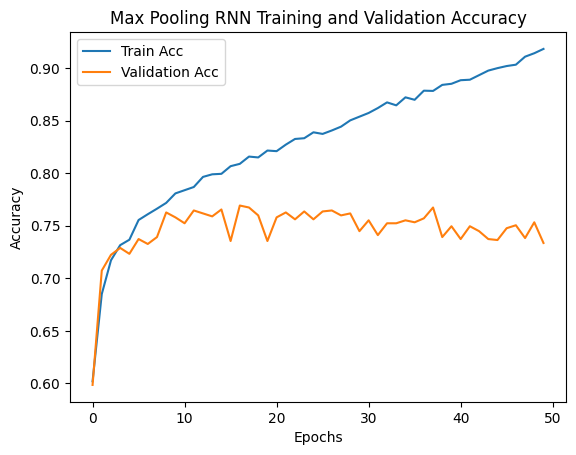

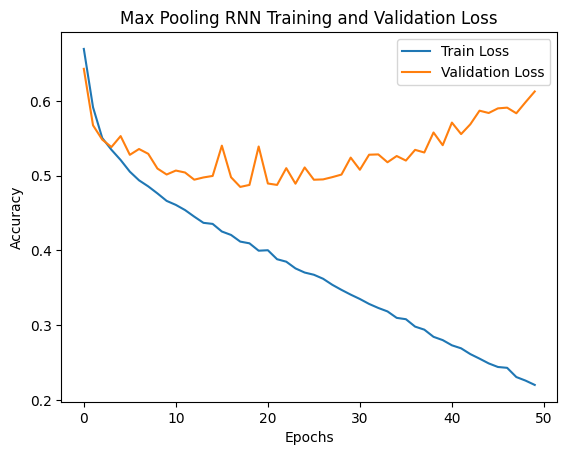

best performance (lowest validation loss) with validation acc: 0.7673545966228893 validation loss: 0.4850129371180254


In [15]:
plot({"Train Acc": train_acc_max, "Validation Acc": validation_acc_max}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy")
plot({"Train Loss": train_loss_max, "Validation Loss": validation_loss_max}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss")

i = validation_loss_max.index(min(validation_loss_max))
print("best performance (lowest validation loss) with validation acc:", validation_acc_max[i], "validation loss:", validation_loss_max[i])

Let's see the performance with early stopping!

In [ ]:
max_pool_rnn = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_max_early_stop, validation_acc_max_early_stop, train_loss_max_early_stop, validation_loss_max_early_stop = train_early_stop(max_pool_rnn, optim, criterion, train_dataloader, validation_dataloader)

Epoch 1, Train Loss: 0.6653, Validate Loss: 0.6135
Epoch:1 	 Train Acc:0.6017584994138335 	 Validation Acc:0.6641651031894934
Epoch 2, Train Loss: 0.5749, Validate Loss: 0.5615
Epoch:2 	 Train Acc:0.7031652989449003 	 Validation Acc:0.723264540337711
Epoch 3, Train Loss: 0.5500, Validate Loss: 0.5425
Epoch:3 	 Train Acc:0.7181711606096132 	 Validation Acc:0.7392120075046904
Epoch 4, Train Loss: 0.5307, Validate Loss: 0.5626
Epoch:4 	 Train Acc:0.7344665885111371 	 Validation Acc:0.7195121951219512
Epoch 5, Train Loss: 0.5171, Validate Loss: 0.5350
Epoch:5 	 Train Acc:0.742672919109027 	 Validation Acc:0.7363977485928705
Epoch 6, Train Loss: 0.5057, Validate Loss: 0.5180
Epoch:6 	 Train Acc:0.7467760844079718 	 Validation Acc:0.7410881801125704
Epoch 7, Train Loss: 0.4985, Validate Loss: 0.5247
Epoch:7 	 Train Acc:0.7560375146541618 	 Validation Acc:0.7439024390243902
Epoch 8, Train Loss: 0.4902, Validate Loss: 0.5074
Epoch:8 	 Train Acc:0.7616647127784291 	 Validation Acc:0.74859287054

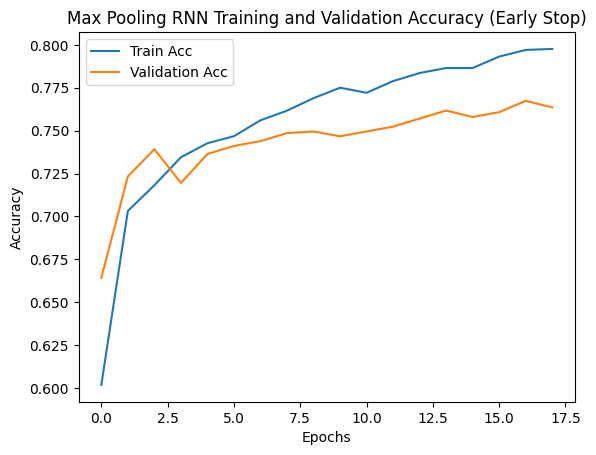

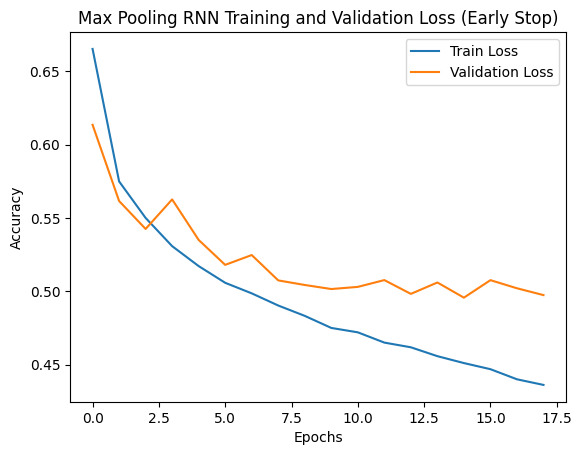

best performance (lowest validation loss) with validation acc: 0.7579737335834896 validation loss: 0.4955994206316331


In [24]:
plot({"Train Acc": train_acc_max_early_stop, "Validation Acc": validation_acc_max_early_stop}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_max_early_stop, "Validation Loss": validation_loss_max_early_stop}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss (Early Stop)")

i = validation_loss_max_early_stop.index(min(validation_loss_max_early_stop))
print("best performance (lowest validation loss) with validation acc:", validation_acc_max_early_stop[i], "validation loss:", validation_loss_max_early_stop[i])

In [25]:
print("Last Max Pooling RNN performance with validation acc:", validation_acc_max_early_stop[-1], "validation loss:", validation_loss_max_early_stop[-1], "\n")

test_accuracy_max_pool = test_performance(test_dataloader, max_pool_rnn)
print("Max Pooling RNN Test accuracy:", test_accuracy_max_pool)

Last Max Pooling RNN performance with validation acc: 0.7636022514071295 validation loss: 0.49733849308070016 

Max Pooling RNN Test accuracy: 0.7607879924953096


#### Sum Pooling RNN

In [34]:
# using nn.Embeddings 
class SumPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(SumPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Sum pooling
        res = torch.sum(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [35]:
sum_pool_rnn = SumPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(sum_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_sum_rnn, validation_acc_sum_rnn, train_loss_sum_rnn, validation_loss_sum_rnn = train_early_stop(sum_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, patience=5)

Epoch 1, Train Loss: 0.6791, Validate Loss: 0.6447
Epoch:1 	 Train Acc:0.6049237983587339 	 Validation Acc:0.6238273921200751
Epoch 2, Train Loss: 0.5936, Validate Loss: 0.6089
Epoch:2 	 Train Acc:0.6910902696365768 	 Validation Acc:0.6848030018761726
Epoch 3, Train Loss: 0.5776, Validate Loss: 0.6196
Epoch:3 	 Train Acc:0.7017584994138335 	 Validation Acc:0.648217636022514
Epoch 4, Train Loss: 0.5765, Validate Loss: 0.5846
Epoch:4 	 Train Acc:0.7048065650644784 	 Validation Acc:0.6923076923076923
Epoch 5, Train Loss: 0.5650, Validate Loss: 0.5834
Epoch:5 	 Train Acc:0.7152403282532239 	 Validation Acc:0.7148217636022514
Epoch 6, Train Loss: 0.5649, Validate Loss: 0.5711
Epoch:6 	 Train Acc:0.711137162954279 	 Validation Acc:0.7204502814258912
Epoch 7, Train Loss: 0.5573, Validate Loss: 0.6037
Epoch:7 	 Train Acc:0.7232121922626026 	 Validation Acc:0.7035647279549718
Epoch 8, Train Loss: 0.5571, Validate Loss: 0.5574
Epoch:8 	 Train Acc:0.7194607268464244 	 Validation Acc:0.71106941838

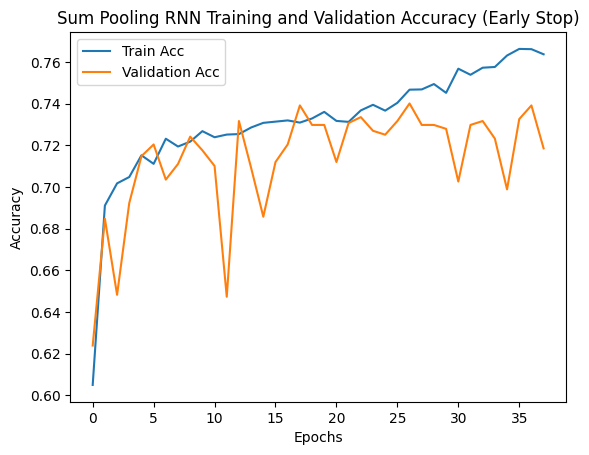

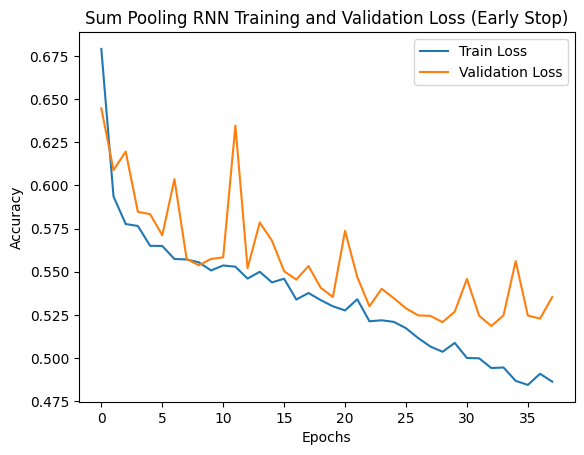

best performance (lowest validation loss) with validation acc: 0.7317073170731707 validation loss: 0.5185154281994876


In [36]:
plot({"Train Acc": train_acc_sum_rnn, "Validation Acc": validation_acc_sum_rnn}, x_label="Epochs", y_label="Accuracy", title="Sum Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_sum_rnn, "Validation Loss": validation_loss_sum_rnn}, x_label="Epochs", y_label="Accuracy", title="Sum Pooling RNN Training and Validation Loss (Early Stop)")


i = validation_loss_sum_rnn.index(min(validation_loss_sum_rnn))
print("best performance (lowest validation loss) with validation acc:", validation_acc_sum_rnn[i], "validation loss:", validation_loss_sum_rnn[i])

In [37]:
print("Last Sum Pooling RNN performance with validation acc:", validation_acc_sum_rnn[-1], "validation loss:", validation_loss_sum_rnn[-1], "\n")

test_accuracy_sum_pool = test_performance(test_dataloader, sum_pool_rnn)
print("Sum Pooling RNN Test accuracy:", test_accuracy_sum_pool)

Last Sum Pooling RNN performance with validation acc: 0.7185741088180112 validation loss: 0.5353173271698111 

Sum Pooling RNN Test accuracy: 0.7363977485928705


#### Mean Pooling RNN

In [38]:
class MeanPoolRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch:torch.tensor, padding_idx: int):
        super(MeanPoolRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Mean pooling
        res = torch.mean(out, dim=1)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)

        return res

In [39]:
mean_pool_rnn = MeanPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(mean_pool_rnn.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_mean_rnn, validation_acc_mean_rnn, train_loss_mean_rnn, validation_loss_mean_rnn = train_early_stop(mean_pool_rnn, optim, criterion, train_dataloader, validation_dataloader, patience=5)

Epoch 1, Train Loss: 0.6613, Validate Loss: 0.5998
Epoch:1 	 Train Acc:0.5902696365767878 	 Validation Acc:0.6885553470919324
Epoch 2, Train Loss: 0.5788, Validate Loss: 0.5639
Epoch:2 	 Train Acc:0.6961313012895662 	 Validation Acc:0.7120075046904315
Epoch 3, Train Loss: 0.5589, Validate Loss: 0.5631
Epoch:3 	 Train Acc:0.7104337631887456 	 Validation Acc:0.700750469043152
Epoch 4, Train Loss: 0.5494, Validate Loss: 0.5513
Epoch:4 	 Train Acc:0.7192262602579133 	 Validation Acc:0.7148217636022514
Epoch 5, Train Loss: 0.5425, Validate Loss: 0.5561
Epoch:5 	 Train Acc:0.7232121922626026 	 Validation Acc:0.7129455909943715
Epoch 6, Train Loss: 0.5395, Validate Loss: 0.5483
Epoch:6 	 Train Acc:0.7266119577960141 	 Validation Acc:0.7204502814258912
Epoch 7, Train Loss: 0.5361, Validate Loss: 0.5389
Epoch:7 	 Train Acc:0.7279015240328254 	 Validation Acc:0.7195121951219512
Epoch 8, Train Loss: 0.5309, Validate Loss: 0.5539
Epoch:8 	 Train Acc:0.7357561547479484 	 Validation Acc:0.7148217636

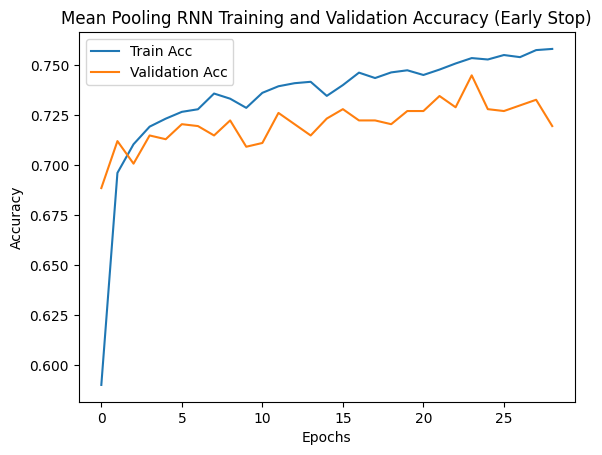

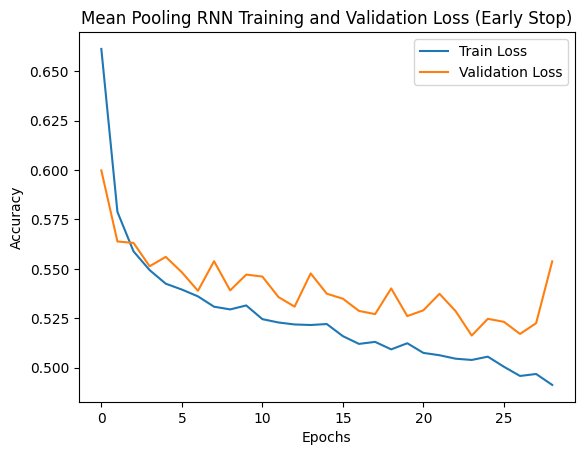

best performance (lowest validation loss) with validation acc: 0.7448405253283302 validation loss: 0.5162702518350938


In [40]:
plot({"Train Acc": train_acc_mean_rnn, "Validation Acc": validation_acc_mean_rnn}, x_label="Epochs", y_label="Accuracy", title="Mean Pooling RNN Training and Validation Accuracy (Early Stop)")
plot({"Train Loss": train_loss_mean_rnn, "Validation Loss": validation_loss_mean_rnn}, x_label="Epochs", y_label="Accuracy", title="Mean Pooling RNN Training and Validation Loss (Early Stop)")

i = validation_acc_mean_rnn.index(max(validation_acc_mean_rnn))
print("best performance (lowest validation loss) with validation acc:", max(validation_acc_mean_rnn), "validation loss:", validation_loss_mean_rnn[i])

In [41]:
print("Last Mean Pooling RNN performance with validation acc:", validation_acc_mean_rnn[-1], "validation loss:", validation_loss_mean_rnn[-1], "\n")

test_accuracy_mean_pool = test_performance(test_dataloader, mean_pool_rnn)
print("Mean Pooling RNN Test accuracy:", test_accuracy_mean_pool)

Last Mean Pooling RNN performance with validation acc: 0.7195121951219512 validation loss: 0.5538282052559012 

Mean Pooling RNN Test accuracy: 0.725140712945591


Let's collate the results of the different models and their performances.

In [87]:
print("Vanilla RNN using hidden state", test_accuracy_gradient)
print("Vanilla RNN using last output", test_accuracy_last_output)
print("Vanilla RNN using max pooling", test_accuracy_max_pool)
print("Vanilla RNN using sum pooling", test_accuracy_sum_pool)
print("Vanilla RNN using mean pooling", test_accuracy_mean_pool)

Vanilla RNN using hidden state 0.7485928705440901
Vanilla RNN using last output 0.7495309568480301
Vanilla RNN using max pooling 0.7607879924953096
Vanilla RNN using sum pooling 0.7363977485928705
Vanilla RNN using mean pooling 0.725140712945591


The results show that max pooling achieves a better result than just passing the last layer, sum pooling and average pooling. This could be due to the fact that max pooling picks the most significant word of the sentences, that significantly determines the sentiment of the overall sentence. 

### Sorted dataset input vs Unsorted dataset input

We tried sorting the dataset before training.

In [91]:
train_dataset_ed_sorted = EmbeddingsDataset(
    train_dataset["text"], train_dataset["label"],
    word_embeddings=word_embeddings,
    sort=True,
)
validation_dataset_ed_sorted = EmbeddingsDataset(
    validation_dataset["text"], validation_dataset["label"],
    word_embeddings=word_embeddings,
    sort=True,
)

pad_value = word_embeddings.pad_idx
# implement minibatch training
train_dataloader_sorted = DataLoader(
    train_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)
validation_dataloader_sorted = DataLoader(
    validation_dataset_ed_sorted,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: pad_collate(x, pad_value),
)

#### Sort on max pooling

In [62]:
max_pool_rnn_sorted_train = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn_sorted_train.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_max_sorted_train, validation_acc_max_sorted_train, train_loss_max_sorted_train, validation_loss_max_sorted_train = train_early_stop(max_pool_rnn_sorted_train, optim, criterion, train_dataloader_sorted, validation_dataloader, patience=5)

Epoch 1, Train Loss: 0.6883, Validate Loss: 0.6790
Epoch:1 	 Train Acc:0.5432590855803048 	 Validation Acc:0.624765478424015
Epoch 2, Train Loss: 0.6581, Validate Loss: 0.6301
Epoch:2 	 Train Acc:0.652989449003517 	 Validation Acc:0.6604127579737336
Epoch 3, Train Loss: 0.6093, Validate Loss: 0.5932
Epoch:3 	 Train Acc:0.6691676436107855 	 Validation Acc:0.699812382739212
Epoch 4, Train Loss: 0.5779, Validate Loss: 0.5697
Epoch:4 	 Train Acc:0.6990621336459555 	 Validation Acc:0.7223264540337712
Epoch 5, Train Loss: 0.5610, Validate Loss: 0.5564
Epoch:5 	 Train Acc:0.712778429073857 	 Validation Acc:0.7401500938086304
Epoch 6, Train Loss: 0.5493, Validate Loss: 0.5471
Epoch:6 	 Train Acc:0.7221570926143025 	 Validation Acc:0.7410881801125704
Epoch 7, Train Loss: 0.5400, Validate Loss: 0.5380
Epoch:7 	 Train Acc:0.7294255568581477 	 Validation Acc:0.7457786116322702
Epoch 8, Train Loss: 0.5321, Validate Loss: 0.5330
Epoch:8 	 Train Acc:0.7349355216881595 	 Validation Acc:0.7485928705440

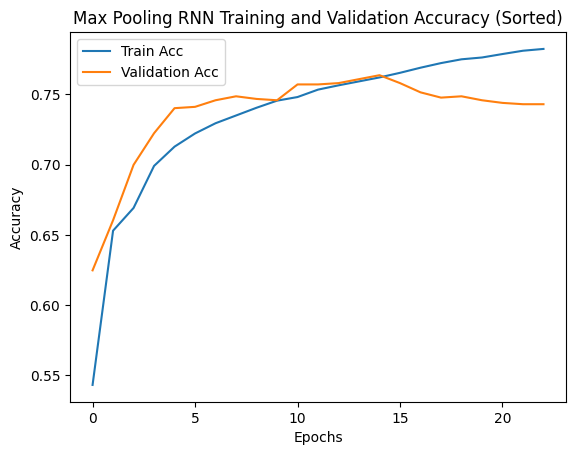

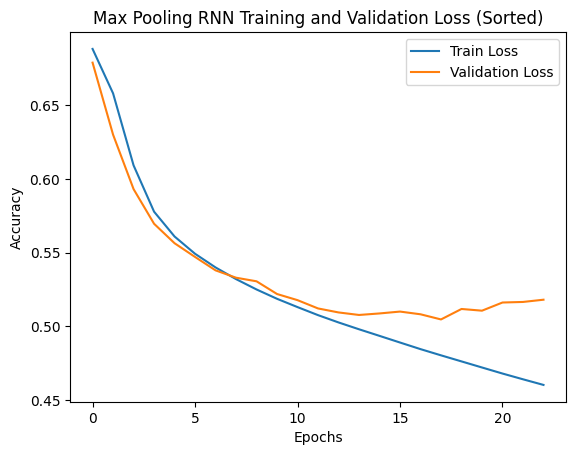

best performance (lowest validation loss) with validation acc: 0.7476547842401501 validation loss: 0.5047251284122467


In [63]:
plot({"Train Acc": train_acc_max_sorted_train, "Validation Acc": validation_acc_max_sorted_train}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy (Sorted)")
plot({"Train Loss": train_loss_max_sorted_train, "Validation Loss": validation_loss_max_sorted_train}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss (Sorted)")

i = validation_loss_max_sorted_train.index(min(validation_loss_max_sorted_train))
print("best performance (lowest validation loss) with validation acc:", validation_acc_max_sorted_train[i], "validation loss:", validation_loss_max_sorted_train[i])

In [68]:
print("Max Pooling RNN (sort train only) performance with validation acc:", validation_acc_max_sorted_train[-1], "validation loss:", validation_loss_max_sorted_train[-1], "\n")

test_accuracy_max_pool_sorted_train = test_performance(test_dataloader, max_pool_rnn_sorted_train)
print("Max Pooling RNN (sort train only) Test accuracy:", test_accuracy_max_pool_sorted_train)

Max Pooling RNN (sort train only) performance with validation acc: 0.7429643527204502 validation loss: 0.5181139917934642 

Max Pooling RNN (sort train only) Test accuracy: 0.7729831144465291


##### What if we sorted training and validation?

In [69]:
max_pool_rnn_sorted_both = MaxPoolRNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=2, num_classes=1, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
optim = torch.optim.Adam(max_pool_rnn_sorted_both.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_acc_max_sorted_both, validation_acc_max_sorted_both, train_loss_max_sorted_both, validation_loss_max_sorted_both = train_early_stop(max_pool_rnn_sorted_both, optim, criterion, train_dataloader_sorted, validation_dataloader_sorted, patience=5)

Epoch 1, Train Loss: 0.6890, Validate Loss: 0.6753
Epoch:1 	 Train Acc:0.5446658851113716 	 Validation Acc:0.6557223264540337
Epoch 2, Train Loss: 0.6604, Validate Loss: 0.6256
Epoch:2 	 Train Acc:0.642672919109027 	 Validation Acc:0.6613508442776735
Epoch 3, Train Loss: 0.6132, Validate Loss: 0.5886
Epoch:3 	 Train Acc:0.6710433763188746 	 Validation Acc:0.699812382739212
Epoch 4, Train Loss: 0.5846, Validate Loss: 0.5672
Epoch:4 	 Train Acc:0.6955451348182884 	 Validation Acc:0.7166979362101313
Epoch 5, Train Loss: 0.5694, Validate Loss: 0.5536
Epoch:5 	 Train Acc:0.7045720984759671 	 Validation Acc:0.724202626641651
Epoch 6, Train Loss: 0.5583, Validate Loss: 0.5434
Epoch:6 	 Train Acc:0.7146541617819461 	 Validation Acc:0.7317073170731707
Epoch 7, Train Loss: 0.5491, Validate Loss: 0.5346
Epoch:7 	 Train Acc:0.7246189917936694 	 Validation Acc:0.7382739212007504
Epoch 8, Train Loss: 0.5412, Validate Loss: 0.5266
Epoch:8 	 Train Acc:0.7281359906213365 	 Validation Acc:0.749530956848

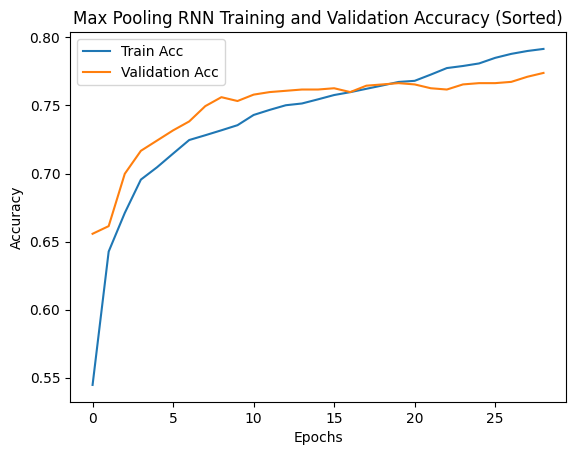

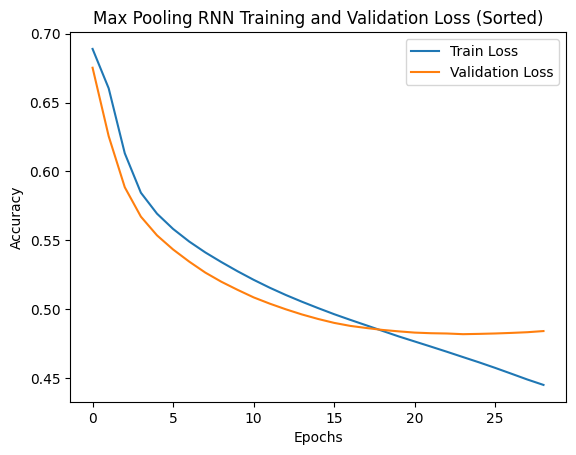

best performance (lowest validation loss) with validation acc: 0.7654784240150094 validation loss: 0.4818817293819259


In [70]:
plot({"Train Acc": train_acc_max_sorted_both, "Validation Acc": validation_acc_max_sorted_both}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Accuracy (Sorted)")
plot({"Train Loss": train_loss_max_sorted_both, "Validation Loss": validation_loss_max_sorted_both}, x_label="Epochs", y_label="Accuracy", title="Max Pooling RNN Training and Validation Loss (Sorted)")

i = validation_loss_max_sorted_both.index(min(validation_loss_max_sorted_both))
print("best performance (lowest validation loss) with validation acc:", validation_acc_max_sorted_both[i], "validation loss:", validation_loss_max_sorted_both[i])

In [71]:
print("Max Pooling RNN (sort both) performance with validation acc:", validation_acc_max_sorted_both[-1], "validation loss:", validation_loss_max_sorted_both[-1], "\n")

test_accuracy_max_pool_sorted_both= test_performance(test_dataloader, max_pool_rnn_sorted_both)
print("Max Pooling RNN (sort both) Test accuracy:", test_accuracy_max_pool_sorted_both)

Max Pooling RNN (sort both) performance with validation acc: 0.773921200750469 validation loss: 0.4841412752866745 

Max Pooling RNN (sort both) Test accuracy: 0.7410881801125704


##### Result & Discussion:

In [72]:
print("Vanilla RNN using max pooling", test_accuracy_max_pool)
print("Vanilla RNN using max pooling with train sorted", test_accuracy_max_pool_sorted_train)
print("Vanilla RNN using max pooling with both train and validation sorted", test_accuracy_max_pool_sorted_both)

Vanilla RNN using max pooling 0.7607879924953096
Vanilla RNN using max pooling with train sorted 0.7729831144465291
Vanilla RNN using max pooling with both train and validation sorted 0.7410881801125704


In [73]:
print("Max Pooling RNN performance with validation acc:", validation_acc_max_early_stop[-1], "validation loss:", validation_loss_max_early_stop[-1])
print("Max Pooling RNN (sort train only) performance with validation acc:", validation_acc_max_sorted_train[-1], "validation loss:", validation_loss_max_sorted_train[-1])
print("Max Pooling RNN (sort both) performance with validation acc:", validation_acc_max_sorted_both[-1], "validation loss:", validation_loss_max_sorted_both[-1])

Max Pooling RNN performance with validation acc: 0.7636022514071295 validation loss: 0.49733849308070016
Max Pooling RNN (sort train only) performance with validation acc: 0.7429643527204502 validation loss: 0.5181139917934642
Max Pooling RNN (sort both) performance with validation acc: 0.773921200750469 validation loss: 0.4841412752866745


We noticed by sorting, we achieved a much smoother training curve and higher test accuracy. We believe this is since the model now can learn from the shortest sentence how to identify the key feature first before learning from the longer one.

However, we also noticed that when sorting both train set and validation set, the validation accuracy increases but test accuracy significantly drops. We believed this is if we are sorting both train and validation, the model overfits much faster and failed to generalize when the dataset is unsorted.

Hence, for our subsequent model, we will used the sorted train set with unsorted validation set to train our model.

### Hyperparameter Search: Grid Search 

#### Define our final model

Based on our exploration, we will now formulate our final vanilla RNN that integrates all our findings and improvements found along the way. We will use 
* 2 layers of RNN
* Use pad_sequence to deal with paddings
* Max Pooling
* Sorted Dataset
* Dropout (0.3).
  
We added dropout here to reduce the chances of overfitting.

The graph below represents the structure of our final RNN model.

![title](vanilla_RNN_final.jpg)

In [88]:
# using nn.Embeddings 
class FinalVanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,  embedding_matrix_torch:torch.tensor, padding_idx: int, drop_out=0.3):
        super(FinalVanillaRNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=padding_idx)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.drop_out = nn.Dropout(drop_out)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x).float()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float).to(x.device)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Max pooling
        res, _ = torch.max(out, dim=1)
        # Only take the last output for each sequence
        res = self.drop_out(res)
        # Pass through the fully connected layer
        res = self.fc(res)
        # Apply sigmoid activation (for binary classification)
        res = self.sigmoid(res)
        
        return res


In [89]:
# init searching configurations 
no_epochs = [100, 200, 300]
lrs = [0.0001, 0.001]
batch_sizes = [32, 64, 128, 256]
optimizers = [torch.optim.Adam, torch.optim.SGD]

# set fixed hyperparameters
hidden_size=128
num_layers=2 
dropout=0.3

In [90]:
import logging 
logging.basicConfig(
    filename='find_optimal_hyperparams_mask_max_sorted.log',       # Name of the log file
    level=logging.INFO,        # Set the logging level (INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log message format
    datefmt='%Y-%m-%d %H:%M:%S'  # Date format in log messages
)

In [93]:
from collections import defaultdict 
def find_optimal_model(no_epochs, lrs, optimizers, batch_sizes, dropout=dropout, hidden_size=hidden_size, num_layers=num_layers, pad_value = word_embeddings.pad_idx):
  """
    Finds optimal hyperparameters by grid search
  """
  # train_dataset_ed = EmbeddingsDataset(train_dataset['text'], train_dataset['label'])
  # validation_dataset_ed = EmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
  criterion = nn.BCELoss()
  results = defaultdict(list) # {[lr, batch_size, optimizer, no_epoch]: [train_loss, train_acc, validate_loss, validation_acc, min_validation_loss, early_stopped?]} 
  for lr in lrs: 
    for batch_size in batch_sizes: 
      # initialize train loader and validate loader for minibatch training 
      for optim_index, optimizer in enumerate(optimizers): 
        for no_epoch in no_epochs: # for each of the number of epochs configuration
          last_min_validate_acc = None # from the EarlyStopper, it keeps track of the last min validation accuracy,
          # this is different from last validate loss which is just from the validate testing step
          early_stopped = False 
          early_stopper = EarlyStopper()
          model = FinalVanillaRNN(input_size=EMBEDDING_DIM, hidden_size=hidden_size, num_layers=num_layers, num_classes=1, drop_out=dropout, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
          optim = optimizer(model.parameters(), lr=lr)  
          logging.info(f"MODEL CONFIGURATIONS: lr: {lr}, batch_size: {batch_size}, optimizer: {optim_index}, no_epoch: {no_epoch}")
          print(f"MODEL CONFIGURATIONS: lr: {lr}, batch_size: {batch_size}, optimizer: {optim_index}, no_epoch: {no_epoch}")
          for i in range(no_epoch): # train and validate for every epoch 
            # train loop 
            train_loss, train_acc = train_loop_bce(train_dataloader_sorted, model, criterion, optim)
            # validate loop 
            validate_loss, validate_acc = test_loop_bce(validation_dataloader, model, criterion)
            if early_stopper.early_stop(validate_loss):
              # when_early_stopped = no_epoch 
              # last_train_acc_in_epochs = train_acc 
              # last_validate_acc_in_epochs = validate_acc 
              last_min_validate_loss = early_stopper.get_last_min_validation_loss()
              
              logging.info(f"\n{lr, batch_size, optim_index, no_epoch}: Early Stopped at {i+1}th epoch \n") 
              logging.info(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}, last min validate acc: {last_min_validate_loss}")   
              logging.info(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
              logging.info("============================================")
              print(f"\n{lr, batch_size, optim_index, no_epoch}: Early Stopped at {i+1}th epoch \n") 
              print(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}, last min validate acc: {last_min_validate_loss}")   
              print(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
              print("============================================")
              results[f"[{lr}, {batch_size}, {optim_index}, {no_epoch}]"] = [train_loss, train_acc, validate_loss, validate_acc, last_min_validate_loss, True] 
              
              early_stopped = True
              break
          if not early_stopped:
            logging.info(f"\n{lr, batch_size, optim_index, no_epoch}:") 
            logging.info(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}")   
            logging.info(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
            logging.info("============================================")
            print(f"\n{lr, batch_size, optim_index, no_epoch}:") 
            print(f"last_trained_acc: {train_acc}, last_validate_acc: {validate_acc}")   
            print(f"last_train_loss: {train_loss}, last_validate_loss:  {validate_loss}")
            print("============================================")
            results[f"[{lr}, {batch_size}, {optim_index}, {no_epoch}]"] = [train_loss, train_acc, validate_loss, validate_acc, None, False]

  return results         

In [94]:
results = find_optimal_model(no_epochs=no_epochs, lrs=lrs, optimizers=optimizers, batch_sizes=batch_sizes)

MODEL CONFIGURATIONS: lr: 0.0001, batch_size: 32, optimizer: 0, no_epoch: 100

(0.0001, 32, 0, 100): Early Stopped at 14th epoch 

last_trained_acc: 0.7447831184056272, last_validate_acc: 0.7307692307692307, last min validate acc: 0.5313962058109396
last_train_loss: 0.5094707062405147, last_validate_loss:  0.5351224287467844
MODEL CONFIGURATIONS: lr: 0.0001, batch_size: 32, optimizer: 0, no_epoch: 200

(0.0001, 32, 0, 200): Early Stopped at 13th epoch 

last_trained_acc: 0.748651817116061, last_validate_acc: 0.7457786116322702, last min validate acc: 0.5240716522230822
last_train_loss: 0.5080361879720223, last_validate_loss:  0.5261357312693316
MODEL CONFIGURATIONS: lr: 0.0001, batch_size: 32, optimizer: 0, no_epoch: 300

(0.0001, 32, 0, 300): Early Stopped at 19th epoch 

last_trained_acc: 0.763305978898007, last_validate_acc: 0.7345215759849906, last min validate acc: 0.5319973651100608
last_train_loss: 0.48719505965709686, last_validate_loss:  0.5433211011045119
MODEL CONFIGURATIONS

In [95]:
import pickle 
pickle.dump(results, open("results_nicole_find_optimal_params_mask_max_sorted.pkl", "wb"))

In [96]:
sorted_results = sorted(results.items(), key=lambda x: x[1][3], reverse=True)

In [97]:
print(sorted_results[:10])

[('[0.001, 32, 0, 100]', [0.45409725930137135, 0.7871043376318875, 0.522116515566321, 0.7560975609756098, 0.508669367607902, True]), ('[0.0001, 256, 0, 100]', [0.4734299997711896, 0.7704572098475967, 0.5092878280317082, 0.7514071294559099, 0.5043424814939499, True]), ('[0.001, 128, 0, 100]', [0.4352722965487827, 0.8005861664712779, 0.5199484851430444, 0.7495309568480301, 0.5123754695934408, True]), ('[0.001, 256, 0, 100]', [0.4831264081519195, 0.7694021101992966, 0.5233593381503049, 0.7485928705440901, 0.5182462325867485, True]), ('[0.001, 32, 0, 200]', [0.46659984425659035, 0.7794841735052755, 0.525624419836437, 0.7476547842401501, 0.5155338811523774, True]), ('[0.0001, 32, 0, 200]', [0.5080361879720223, 0.748651817116061, 0.5261357312693316, 0.7457786116322702, 0.5240716522230822, True]), ('[0.001, 64, 0, 100]', [0.4241915133952648, 0.804337631887456, 0.5153651535511017, 0.7448405253283302, 0.5012624815982931, True]), ('[0.001, 256, 0, 200]', [0.3973318570841118, 0.8182883939038686, 

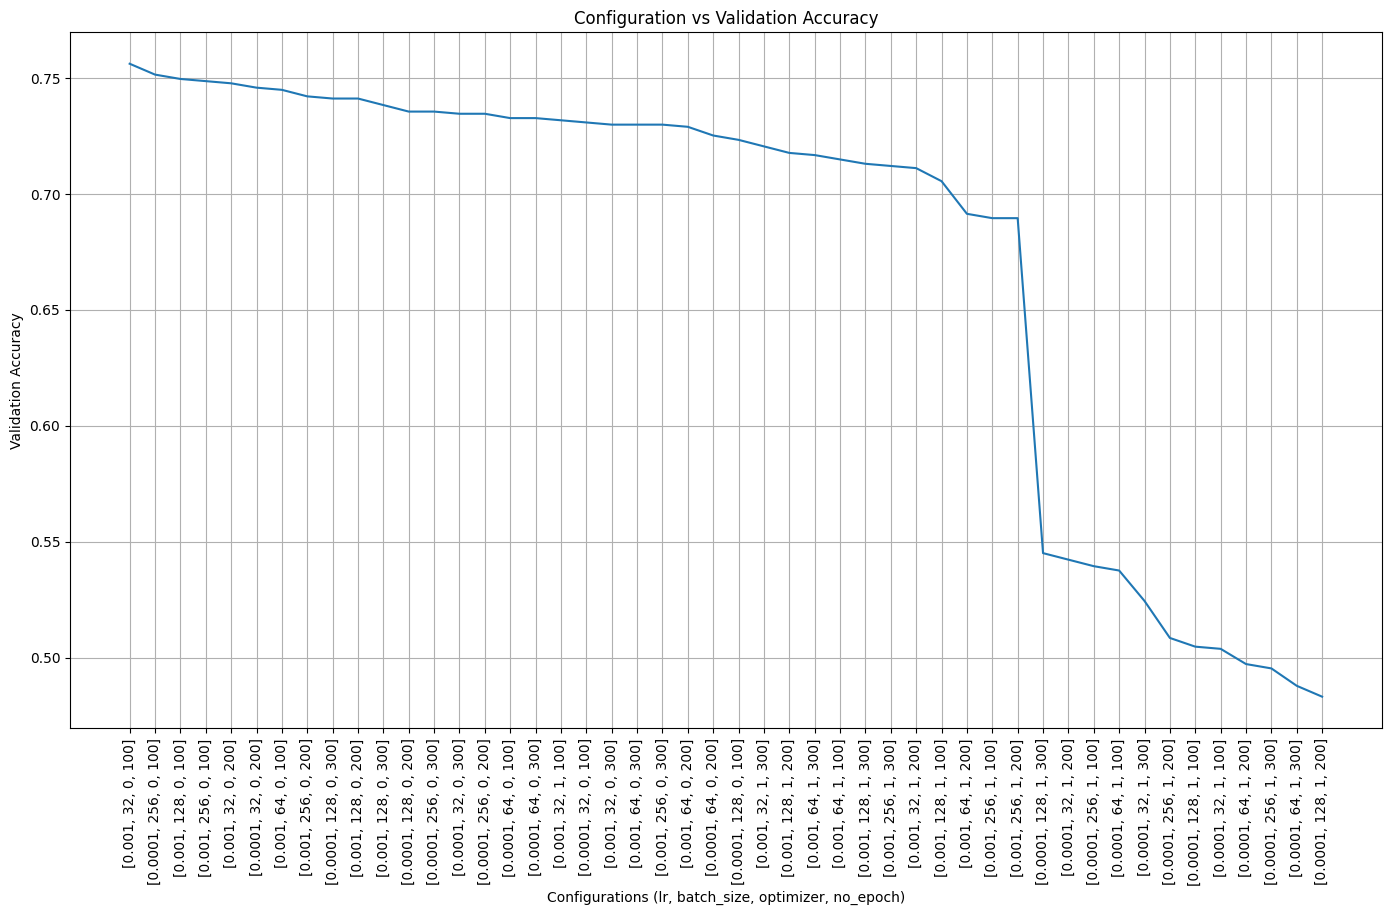

In [98]:
configs = [x[0] for x in sorted_results]
validate_accs = [x[1][3] for x in sorted_results]
plt.figure(figsize=(14,8))
plt.xticks(rotation=90)
plt.xlabel("Configurations (lr, batch_size, optimizer, no_epoch)")
plt.ylabel("Validation Accuracy")
plt.title("Configuration vs Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.plot(configs, validate_accs)


In [99]:
# train the best model 
best_lr = 0.0001
best_bs = 32 
best_optimizer = torch.optim.Adam
best_no_epoch = 100

# fixed parameters
hidden_size=128
num_layers=2 
dropout=0.3


In [105]:
# Test loop
# (0.0001, 32, 0, 100): Early Stopped at 33th epoch  

def train_optimal_model(best_bs=best_bs, best_lr=best_lr, best_no_epoch=best_no_epoch, best_optimizer=best_optimizer, dropout=0.3, num_layers=2, hidden_size=128):
    validation_accs = [] 
    validation_losses = [] 
    train_losses = [] 
    train_accs = [] 
    opt_model = FinalVanillaRNN(input_size=EMBEDDING_DIM, hidden_size=hidden_size, num_layers=num_layers, num_classes=1, drop_out=dropout, embedding_matrix_torch=word_embeddings.to_tensor, padding_idx=word_embeddings.pad_idx)
    criterion = nn.BCELoss()
    optim = best_optimizer(opt_model.parameters(), lr=best_lr)
    for i in range(14):
        train_loss, train_acc = train_loop_bce(train_dataloader_sorted, opt_model, criterion, optim)
        validate_loss, validate_acc = test_loop_bce(validation_dataloader, opt_model, criterion)
        validation_accs.append(validate_acc)
        validation_losses.append(validate_loss)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
    return opt_model, validation_accs, validation_losses, train_losses, train_accs

# using our best model   
optimal_model_RNN, validation_accs, validation_losses, train_losses, train_accs = train_optimal_model()
torch.save(optimal_model_RNN, "optimal_model_RNN")

In [120]:
max(validation_accs)

0.7542213883677298

In [106]:
test_acc = test_performance(test_dataloader, optimal_model_RNN)
print("The test accuracy of the optimal model is: ", test_acc)

The test accuracy of the optimal model is:  0.7729831144465291


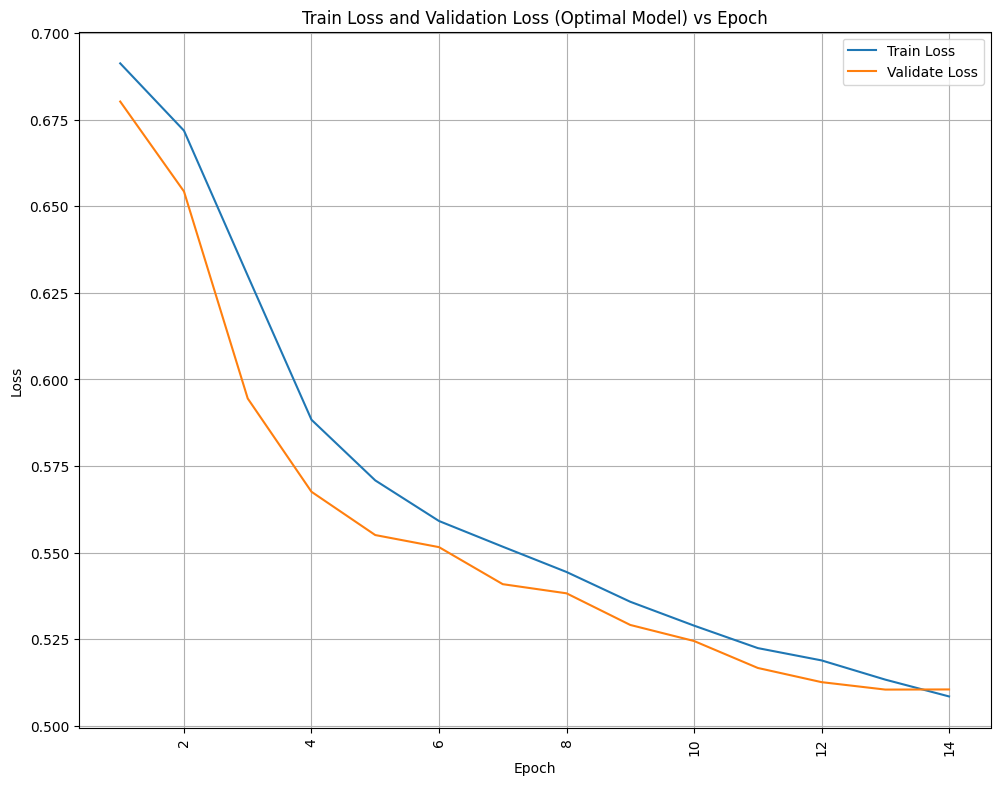

In [112]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss and Validation Loss (Optimal Model) vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.plot([i+1 for i in range(14)], train_losses, label="Train Loss")
plt.plot([i+1 for i in range(14)], validation_losses, label="Validate Loss")
plt.legend()

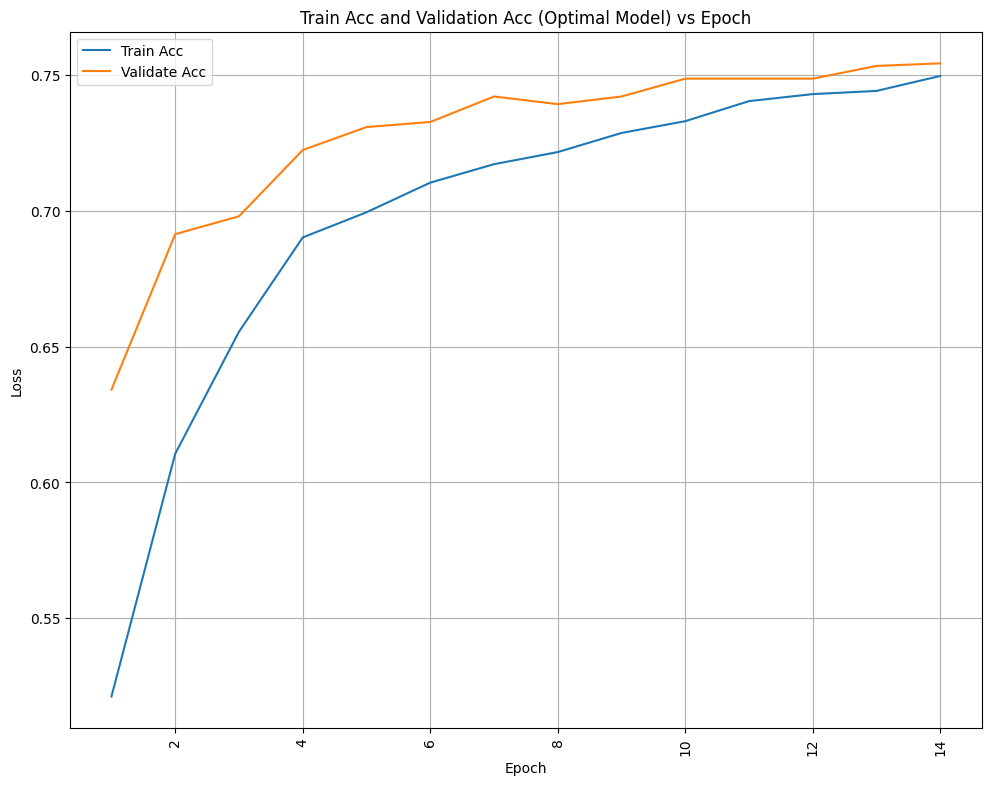

In [113]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Acc and Validation Acc (Optimal Model) vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.plot([i+1 for i in range(14)], train_accs, label="Train Acc")
plt.plot([i+1 for i in range(14)], validation_accs, label="Validate Acc")
plt.legend()

In [115]:
import pandas as pd

# Example data
epochs = list(range(1, 15))

# Creating a DataFrame
metrics_df = pd.DataFrame({
    "Epoch": epochs,
    "Train Loss": train_losses,
    "Validation Loss": validation_losses,
    "Train Accuracy": train_accs,
    "Validation Accuracy": validation_accs
})

# Display the DataFrame
metrics = metrics_df.reset_index(drop=True)
display(metrics)

,Epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,1,0.691209,0.680193,0.521219,0.634146
1,2,0.671788,0.654243,0.610551,0.691370
2,3,0.629934,0.594481,0.655451,0.697936
3,4,0.588346,0.567560,0.690152,0.722326
4,5,0.570845,0.555071,0.699414,0.730769
5,6,0.559123,0.551582,0.710317,0.732645
6,7,0.551711,0.540892,0.717116,0.742026
7,8,0.544412,0.538253,0.721571,0.739212
8,9,0.535816,0.529123,0.728605,0.742026
9,10,0.528928,0.524492,0.732943,0.748593


In [116]:
metrics.to_csv("Part_2_validation_acc_opt_model.csv")

In [117]:
# test the optimal model 
optimal_model_RNN = torch.load("optimal_model_RNN")
test_acc = test_performance(test_dataloader, optimal_model_RNN)

C:\Users\USER\AppData\Local\Temp\ipykernel_33028\3085882787.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimal_model_RNN = torch.load("optimal_model_RNN")


In [118]:
test_acc

0.7720450281425891